*Арешин Станислав Олегович М80-404Б-17*

**Лабораторная работа по эконометрике**

**Анализ временного ряда**

In [1]:
import yfinance as yf  
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import clear_output
%matplotlib inline

# Загрузка данных

Я решил взять данные акций Apple в период 2019-2020 (за этот период картинка лучше всего) и прогнозировать признак Close - цена акции в момент закрытия торогов.

In [2]:
df = yf.download('AAPL','2019-01-02','2020-02-01')
df.sort_index(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.505024,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.669640,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,36.149662,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,36.069202,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.756794,164101200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 273 entries, 2019-01-02 to 2020-01-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       273 non-null    float64
 1   High       273 non-null    float64
 2   Low        273 non-null    float64
 3   Close      273 non-null    float64
 4   Adj Close  273 non-null    float64
 5   Volume     273 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 14.9 KB


In [4]:
df_close = df[['Close']].copy()
df_close.head()

,Close
Date,
2019-01-02,39.480000
2019-01-03,35.547501
2019-01-04,37.064999
2019-01-07,36.982498
2019-01-08,37.687500


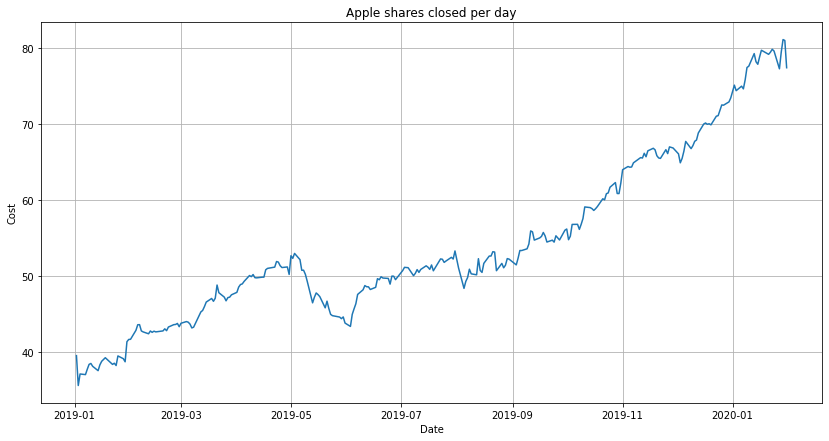

In [5]:
plt.figure(figsize=(14,7))
plt.title('Apple shares closed per day')
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Cost')
plt.grid()

 statsmodels.tsa.seasonal.seasonal_decompose выделят трендовую и сезонную составляющую временного ряда:

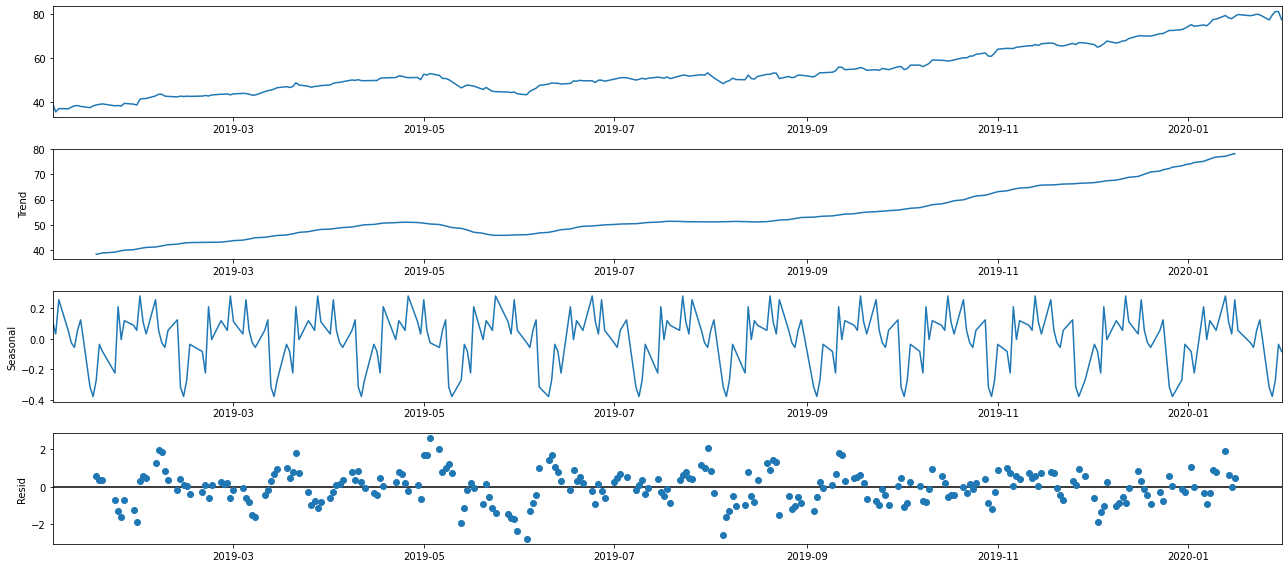

In [6]:
# 5, 20 ,253
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = (18, 8)
decomposition = seasonal_decompose(df_close, model='additive', period=20)
fig = decomposition.plot()

In [7]:
df_close = df_close.reset_index(drop=True)
df_close.head()

,Close
0,39.480000
1,35.547501
2,37.064999
3,36.982498
4,37.687500


# Train-test split

Здесь я делаю train-test split в соотношении 80 на 20 %

In [8]:
df_train = df_close[:int(len(df) * 0.8)]
print(len(df_train))
df_train.head()

218


,Close
0,39.480000
1,35.547501
2,37.064999
3,36.982498
4,37.687500


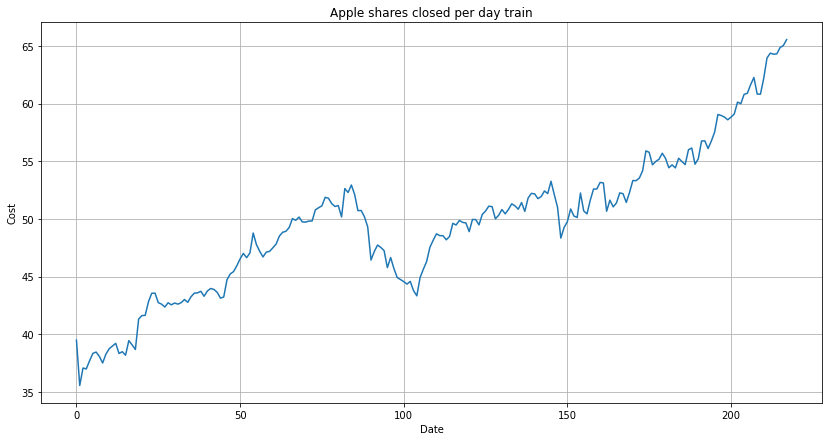

In [9]:
plt.figure(figsize=(14,7))
plt.title('Apple shares closed per day train')
plt.plot(df_train)
plt.xlabel('Date')
plt.ylabel('Cost')
plt.grid()

In [10]:
df_test = df_close[int(len(df) * 0.8):]
print(len(df_test))
df_test.head()

55


,Close
218,65.489998
219,66.117500
220,65.660004
221,66.440002
222,66.775002


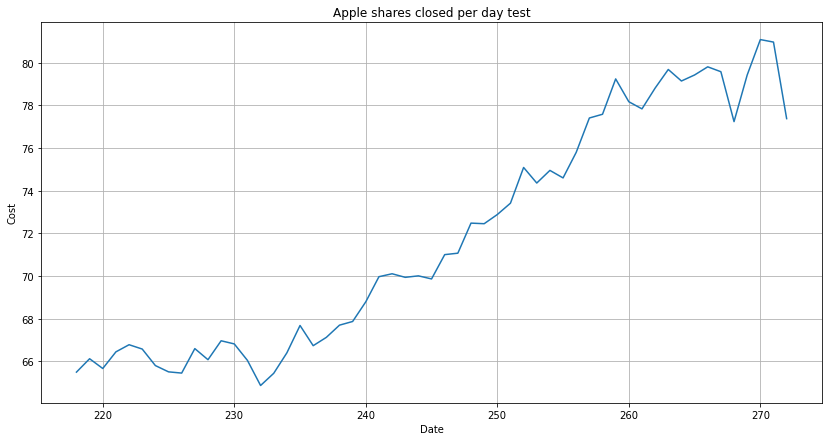

In [11]:
plt.figure(figsize=(14,7))
plt.title('Apple shares closed per day test')
plt.plot(df_test)
plt.xlabel('Date')
plt.ylabel('Cost')
plt.grid()

# Реализация Grid Search (перебор параметров)


## Grid Search SARIMA

Из модели SARIMA можно получить AR, MA, ARMA, ARIMA модели, поэтому была реализована функция перебора параметров для statsmodels.tsa.statespace.sarimax.SARIMAX

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from warnings import catch_warnings
from warnings import filterwarnings

# Прогноз
def sarima_forecast(train, test, config):
    order, sorder, trend = config
    model = SARIMAX(train, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    preds = model_fit.predict(len(train), len(train) + len(test) - 1)
    return preds
 
# Вычисление MAPE
def get_score(train,test, cfg):
    predictions = sarima_forecast(train,test, cfg)
    error = mean_absolute_percentage_error(test, predictions)
    return error
 
# Оценивание модели по MAPE
def score_model(train,test, cfg):
    result = None
    key = str(cfg)
    try:
        with catch_warnings():
            filterwarnings("ignore")
            result = get_score(train,test, cfg)
    except:
        error = None
        
    if result is not None:
        print(f'> Model {key},    MAPE {result}')
    return (key, result)
 
# grid search 
def grid_search(train, test, cfg_list):
    scores = [score_model(train, test, cfg) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

## Grid Search HWES

Тут я реализовал перебор параметров для сглаживания Хольтса - Винтерса с целью поиска наилучшей модели.

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from warnings import catch_warnings
from warnings import filterwarnings

# Прогноз
def smothing_forecast(train, test, config):
    trend, seasonal, seasonal_periods, sm  = config
    model = ExponentialSmoothing(train, trend=trend,  seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit(smoothing_level= sm)
    preds = model_fit.predict(len(train), len(train) + len(test) - 1)
    return preds
 
# Вычисление MAPE
def get_score_sm(train,test, cfg):
    predictions = smothing_forecast(train,test, cfg)
    error = mean_absolute_percentage_error(test, predictions)
    return error
 
# Оценивание модели по MAPE
def score_model_sm(train,test, cfg):
    result = None
    key = str(cfg)
    try:
        with catch_warnings():
            filterwarnings("ignore")
            result = get_score_sm(train,test, cfg)
    except:
        error = None
        
    if result is not None:
        print(f'> Model {key},    MAPE {result}')
    return (key, result)
 
# grid search 
def grid_search_sm(train, test, cfg_list):
    scores = [score_model_sm(train, test, cfg) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

# Предсказание временного ряда

## AR model 

autoregressive models: AR(p) - все параметры кроме p зануляем, перебираем p и trend

In [14]:
def AR_config(seasonal=[0]):
	models = []
	p_params = [1, 2, 3 ,4 ,5]
	d_params = [0]
	q_params = [0]
	t_params = ['n','c','t','ct']
	P_params = [0]
	D_params = [0]
	Q_params = [0]
	m_params = seasonal
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [15]:
cfg_list = AR_config()
scores = grid_search(df_train['Close'].to_numpy(), df_test['Close'].to_numpy(), cfg_list)
clear_output(wait=True)
print('done\n')
print('TOP 3 scores : \n')
for cfg, res in scores[:3]:
    print(f'> Model {cfg},    MAPE {res}')

done

TOP 3 scores : 

> Model [(1, 0, 0), (0, 0, 0, 0), 't'],    MAPE 0.02342426253238507
> Model [(5, 0, 0), (0, 0, 0, 0), 't'],    MAPE 0.0253005303567747
> Model [(3, 0, 0), (0, 0, 0, 0), 't'],    MAPE 0.025469170704316917


Лучшие параметры модели: [(1, 0, 0), (0, 0, 0, 0), 't'], то есть AR(1)

при этом MAPE =  0.02342426253238507

Построим данную модель

In [16]:
model = SARIMAX(df_train['Close'].to_numpy(), order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend='t', enforce_stationarity=False, enforce_invertibility=False)
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -264.454
Date:                Wed, 21 Apr 2021   AIC                            534.908
Time:                        13:45:48   BIC                            545.048
Sample:                             0   HQIC                           539.004
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0009      0.001      0.842      0.400      -0.001       0.003
ar.L1          1.0003      0.003    364.337      0.000       0.995       1.006
sigma2         0.6700      0.041     16.393      0.0

Из SARIMAX result выделим критерии AIC (Информационный критерий Акаике) и BIC (Байесовский информационный критерий).

AIC =  534.908

BIC = 545.048

Тренировочная выборка:

In [17]:
print('train data MAPE: ',mean_absolute_percentage_error(df_train['Close'].to_numpy(), res.predict()))

train data MAPE:  0.01660565549473924


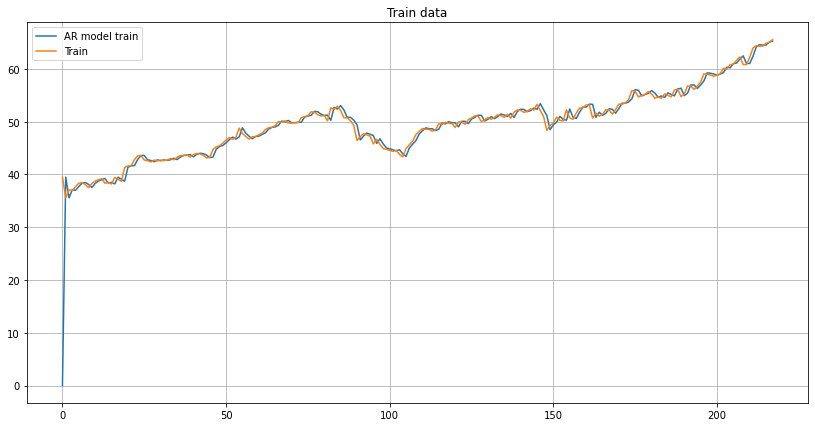

In [18]:
plt.figure(figsize=(14,7))
plt.title('Train data')
plt.plot (res.predict(), label= 'AR model train')
plt.plot(df_train.reset_index(drop=True), label = 'Train')
plt.legend(loc='upper left')
plt.grid()

Сделаем прогноз на весь тестовый датасет

In [19]:
print('test data MAPE: ',mean_absolute_percentage_error(df_test['Close'].to_numpy(), res.predict(len(df_train), len(df_train) + len(df_test) - 1)))

test data MAPE:  0.02342426253238507


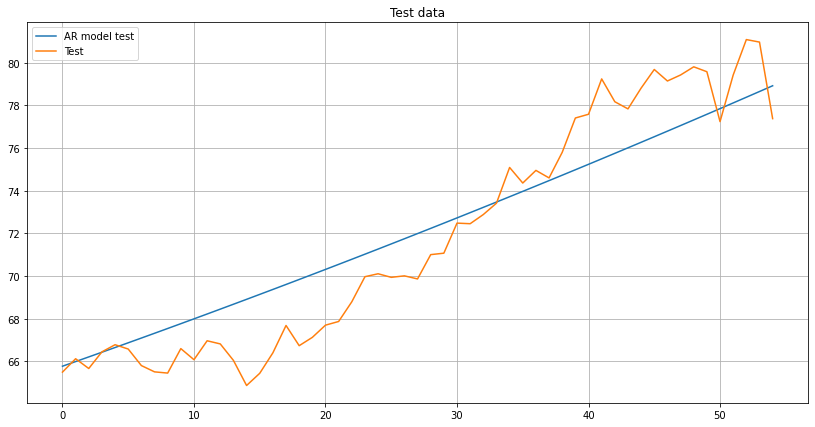

In [20]:
plt.figure(figsize=(14,7))
plt.title('Test data')
plt.plot(res.predict(len(df_train), len(df_train) + len(df_test) - 1), label= 'AR model test')
plt.plot(df_test.reset_index(drop=True), label = 'Test')
plt.legend(loc='upper left')
plt.grid()

Сделаем короткий прогноз (на 6 дней)

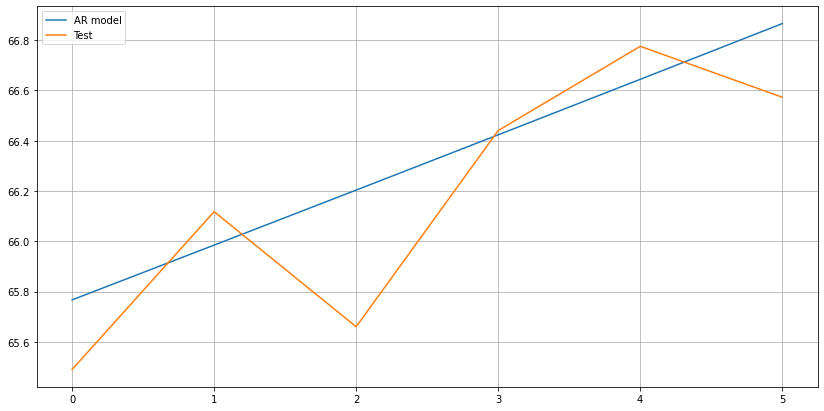

In [21]:
plt.figure(figsize=(14,7))
plt.plot(res.predict(len(df_train), len(df_train)+5), label= 'AR model')
plt.plot(df_test.reset_index(drop=True)[:6], label = 'Test')
plt.legend(loc='upper left')
plt.grid()

## MA model 

moving average models: MA(q) - все параметры кроме q зануляем, перебираем q и trend

In [45]:
def MA_config(seasonal=[0]):
	models = []
	p_params = [0]
	d_params = [0]
	q_params = [1, 2, 3 ,4 ,5]
	t_params = ['n','c','t','ct']
	P_params = [0]
	D_params = [0]
	Q_params = [0]
	m_params = seasonal
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [47]:
cfg_list = MA_config()
scores = grid_search(df_train['Close'].to_numpy(), df_test['Close'].to_numpy(), cfg_list)
clear_output(wait=True)
print('done\n')
print('TOP 3 scores : \n')
for cfg, res in scores[:3]:
    print(f'> Model {cfg},    MAPE {res}')

done

TOP 3 scores : 

> Model [(0, 0, 5), (0, 0, 0, 0), 'ct'],    MAPE 0.12726102167754255
> Model [(0, 0, 3), (0, 0, 0, 0), 'ct'],    MAPE 0.13052905465327297
> Model [(0, 0, 2), (0, 0, 0, 0), 'ct'],    MAPE 0.13167416556351777


Лучшие параметры модели: [(0, 0, 5), (0, 0, 0, 0), 't'], то есть MA(5)

при этом MAPE =  0.12726102167754255

Построим данную модель

In [24]:
model = SARIMAX(df_train['Close'].to_numpy(), order=(0, 0, 5), seasonal_order=(0, 0, 0, 0), trend='ct', enforce_stationarity=False, enforce_invertibility=False)
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(0, 0, 5)   Log Likelihood                -278.303
Date:                Wed, 21 Apr 2021   AIC                            572.606
Time:                        13:45:57   BIC                            599.459
Sample:                             0   HQIC                           583.459
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.8295      0.746     53.390      0.000      38.367      41.292
drift          0.0910      0.005     16.817      0.000       0.080       0.102
ma.L1          1.0934      0.067     16.418      0.0

D:\conda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Из SARIMAX result выделим критерии AIC (Информационный критерий Акаике) и BIC (Байесовский информационный критерий).

AIC =  572.606

BIC = 599.459

Тренировочная выборка:

In [25]:
print('train data MAPE: ',mean_absolute_percentage_error(df_train['Close'].to_numpy(), res.predict()))

train data MAPE:  0.019875968025944258


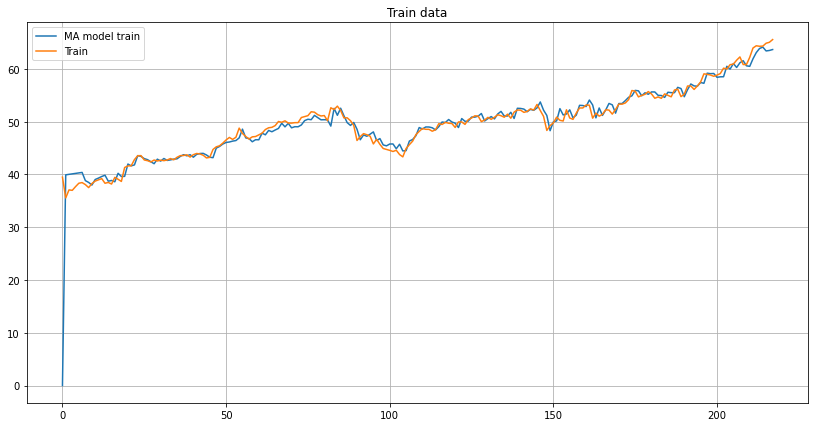

In [26]:
plt.figure(figsize=(14,7))
plt.title('Train data')
plt.plot (res.predict(), label= 'MA model train')
plt.plot(df_train.reset_index(drop=True), label = 'Train')
plt.legend(loc='upper left')
plt.grid()

Сделаем прогноз на весь тестовый датасет

In [27]:
print('test data MAPE: ',mean_absolute_percentage_error(df_test['Close'].to_numpy(), res.predict(len(df_train), len(df_train) + len(df_test) - 1)))

test data MAPE:  0.12726102167754255


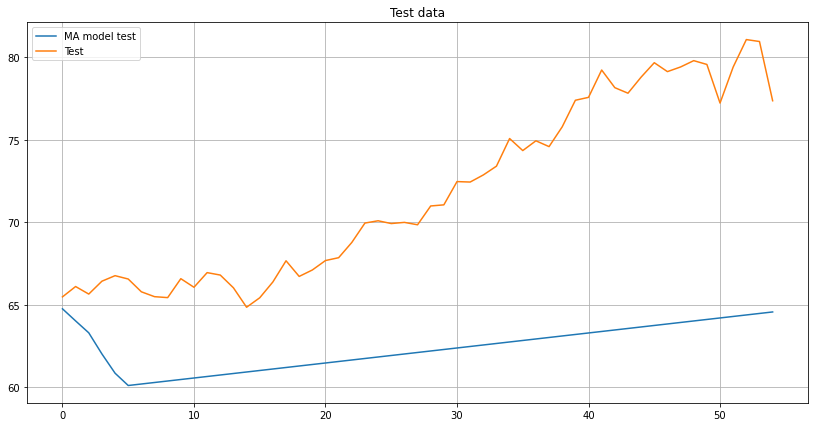

In [28]:
plt.figure(figsize=(14,7))
plt.title('Test data')
plt.plot(res.predict(len(df_train), len(df_train) + len(df_test) - 1), label= 'MA model test')
plt.plot(df_test.reset_index(drop=True), label = 'Test')
plt.legend(loc='upper left')
plt.grid()

## ARMA model 

mixed autoregressive moving average models: ARMA(p, q) - все параметры кроме p и q зануляем, перебираем p, q и trend

In [29]:
def ARMA_config(seasonal=[0]):
	models = []
	# define config lists
	p_params = [1, 2, 3]
	d_params = [0]
	q_params = [1, 2, 3]
	t_params = ['n','c','t','ct']
	P_params = [0]
	D_params = [0]
	Q_params = [0]
	m_params = seasonal
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [30]:
cfg_list = ARMA_config()
scores = grid_search(df_train['Close'].to_numpy(), df_test['Close'].to_numpy(), cfg_list)
clear_output(wait=True)
print('done\n')
print('TOP 3 scores : \n')
for cfg, res in scores[:3]:
    print(f'> Model {cfg},    MAPE {res}')

done

TOP 3 scores : 

> Model [(3, 0, 2), (0, 0, 0, 0), 't'],    MAPE 0.02549486570867855
> Model [(3, 0, 1), (0, 0, 0, 0), 't'],    MAPE 0.025640667172609342
> Model [(1, 0, 3), (0, 0, 0, 0), 't'],    MAPE 0.025669254054550818


Лучшие параметры модели: [(3, 0, 2), (0, 0, 0, 0), 't'], то есть ARMA(3,2)

при этом MAPE =  0.02549486570867855

Построим данную модель

In [31]:
model = SARIMAX(df_train['Close'].to_numpy(), order=(3, 0, 2), seasonal_order=(0, 0, 0, 0), trend='t', enforce_stationarity=False, enforce_invertibility=False)
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -247.826
Date:                Wed, 21 Apr 2021   AIC                            509.652
Time:                        13:46:10   BIC                            533.246
Sample:                             0   HQIC                           519.185
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0.378      0.706      -0.001       0.002
ar.L1          1.3427      0.522      2.573      0.010       0.320       2.366
ar.L2         -0.3144      0.504     -0.624      0.5

D:\conda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Из SARIMAX result выделим критерии AIC (Информационный критерий Акаике) и BIC (Байесовский информационный критерий).

AIC =  509.652

BIC = 533.246

Тренировочная выборка:

In [32]:
print('train data MAPE: ',mean_absolute_percentage_error(df_train['Close'].to_numpy(), res.predict()))

train data MAPE:  0.018292091495712565


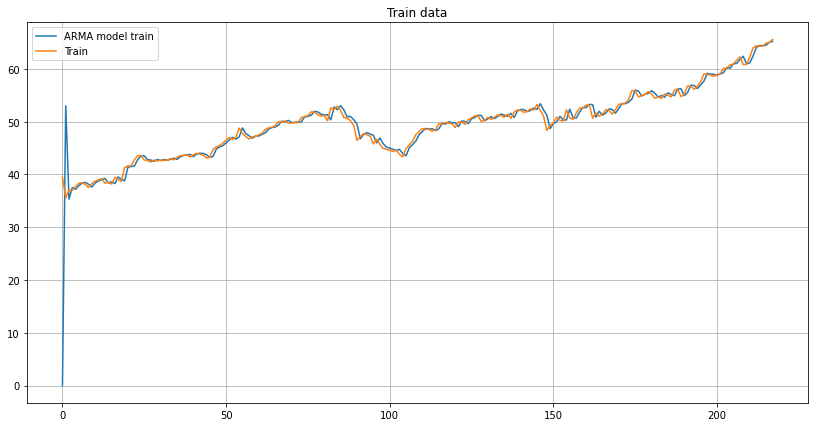

In [33]:
plt.figure(figsize=(14,7))
plt.title('Train data')
plt.plot (res.predict(), label= 'ARMA model train')
plt.plot(df_train.reset_index(drop=True), label = 'Train')
plt.legend(loc='upper left')
plt.grid()

Сделаем прогноз на весь тестовый датасет

In [34]:
print('test data MAPE: ',mean_absolute_percentage_error(df_test['Close'].to_numpy(), res.predict(len(df_train), len(df_train) + len(df_test) - 1)))

test data MAPE:  0.02549486570867855


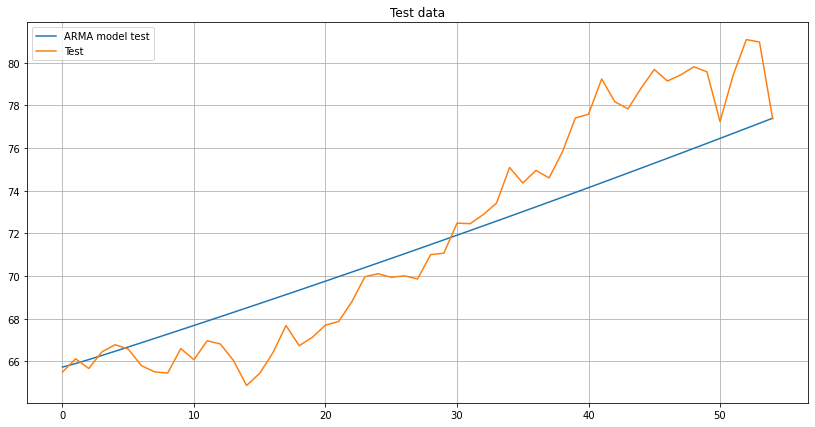

In [35]:
plt.figure(figsize=(14,7))
plt.title('Test data')
plt.plot(res.predict(len(df_train), len(df_train) + len(df_test) - 1), label= 'ARMA model test')
plt.plot(df_test.reset_index(drop=True), label = 'Test')
plt.legend(loc='upper left')
plt.grid()

Сделаем короткий прогноз на 6 дней

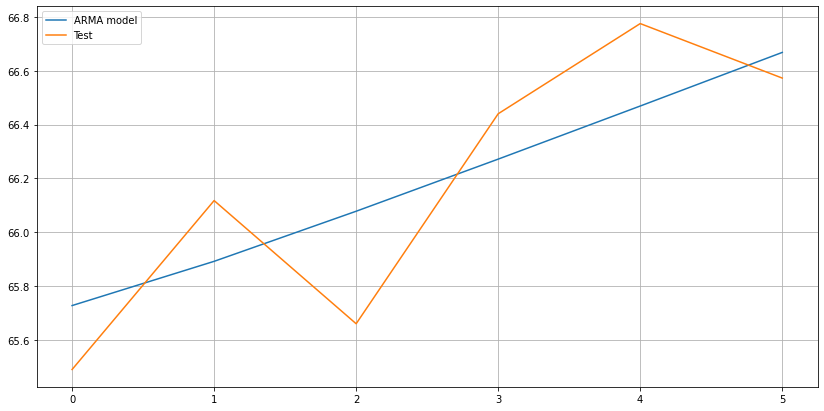

In [36]:
plt.figure(figsize=(14,7))
plt.plot(res.predict(len(df_train), len(df_train) + 5), label= 'ARMA model')
plt.plot(df_test.reset_index(drop=True)[:6], label = 'Test')
plt.legend(loc='upper left')
plt.grid()

## ARIMA model 

integration models: ARIMA(p, d, q) - все параметры кроме p, d, q зануляем, перебираем p, d, q и trend

In [37]:
def ARIMA_config(seasonal=[0]):
	models = []
	# define config lists
	p_params = [1, 2, 3]
	d_params = [1,2]
	q_params = [1, 2, 3]
	t_params = ['n','c','t','ct']
	P_params = [0]
	D_params = [0]
	Q_params = [0]
	m_params = seasonal
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [38]:
cfg_list = ARIMA_config()
scores = grid_search(df_train['Close'].to_numpy(), df_test['Close'].to_numpy(), cfg_list)
clear_output(wait=True)
print('done\n')
print('TOP 3 scores : \n')
for cfg, res in scores[:3]:
    print(f'> Model {cfg},    MAPE {res}')

done

TOP 3 scores : 

> Model [(3, 2, 2), (0, 0, 0, 0), 't'],    MAPE 0.023060497871810182
> Model [(2, 1, 2), (0, 0, 0, 0), 't'],    MAPE 0.023114822121800084
> Model [(1, 1, 2), (0, 0, 0, 0), 't'],    MAPE 0.023116655637654467


Лучшие параметры модели: [(3, 2, 2), (0, 0, 0, 0), 't'], то есть ARIMA(3,2,2)

при этом MAPE =  0.023060497871810182

Построим данную модель

In [39]:
model = SARIMAX(df_train['Close'].to_numpy(), order=(3, 2, 2), seasonal_order=(0, 0, 0, 0), trend='t', enforce_stationarity=False, enforce_invertibility=False)
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -248.602
Date:                Wed, 21 Apr 2021   AIC                            511.203
Time:                        13:46:35   BIC                            534.732
Sample:                             0   HQIC                           520.712
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       1.168e-05   2.56e-05      0.456      0.648   -3.85e-05    6.18e-05
ar.L1         -1.0245      0.160     -6.412      0.000      -1.338      -0.711
ar.L2         -0.2634      0.106     -2.486      0.0

Из SARIMAX result выделим критерии AIC (Информационный критерий Акаике) и BIC (Байесовский информационный критерий).

AIC =  511.203

BIC = 534.732

Тренировочная выборка:

In [40]:
print('train data MAPE: ',mean_absolute_percentage_error(df_train['Close'].to_numpy(), res.predict()))

train data MAPE:  0.020463763628766004


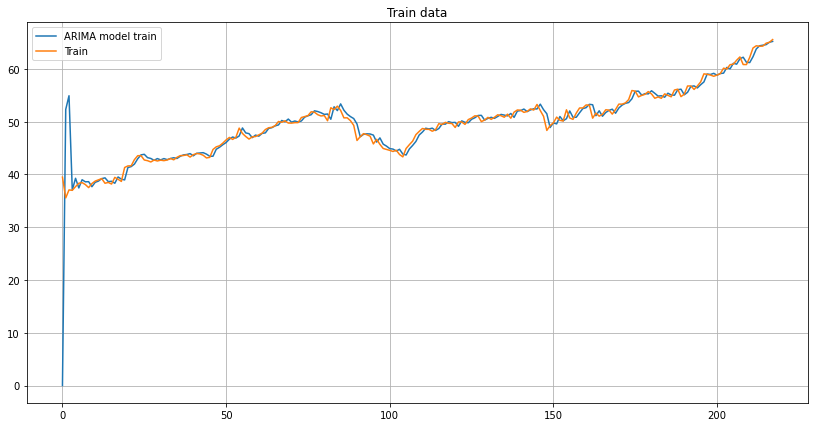

In [41]:
plt.figure(figsize=(14,7))
plt.title('Train data')
plt.plot (res.predict(), label= 'ARIMA model train')
plt.plot(df_train.reset_index(drop=True), label = 'Train')
plt.legend(loc='upper left')
plt.grid()

Построим прогноз на весь тестовый датасет

In [42]:
print('test data MAPE: ',mean_absolute_percentage_error(df_test['Close'].to_numpy(), res.predict(len(df_train), len(df_train) + len(df_test) - 1)))

test data MAPE:  0.023060497871810182


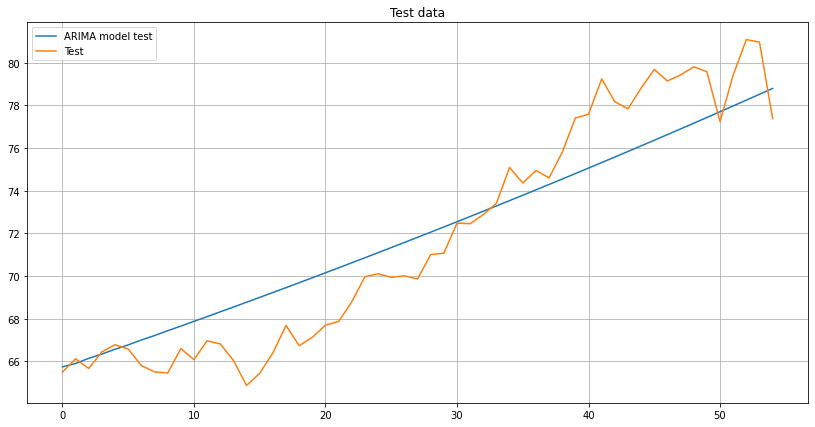

In [43]:
plt.figure(figsize=(14,7))
plt.title('Test data')
plt.plot(res.predict(len(df_train), len(df_train) + len(df_test) - 1), label= 'ARIMA model test')
plt.plot(df_test.reset_index(drop=True), label = 'Test')
plt.legend(loc='upper left')
plt.grid()

Сделаем короткий прогноз на 6 дней

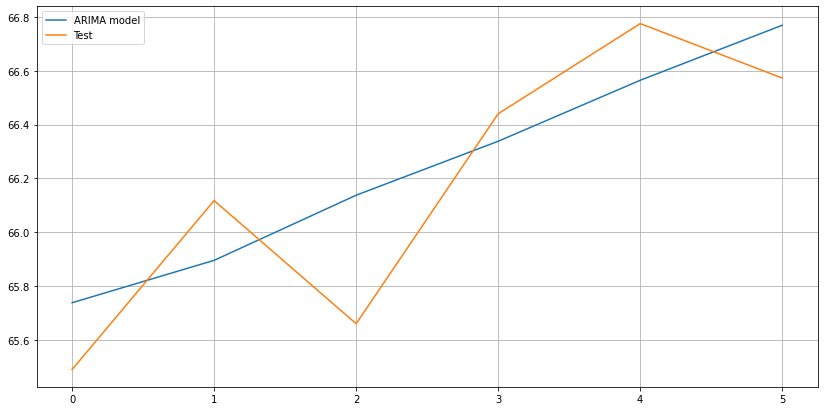

In [44]:
plt.figure(figsize=(14,7))
plt.plot(res.predict(len(df_train), len(df_train) + 5), label= 'ARIMA model')
plt.plot(df_test.reset_index(drop=True)[:6], label = 'Test')
plt.legend(loc='upper left')
plt.grid()

## SARIMA model 

И наконец, самая мощная модель из рассмотренных -  SARIMA(p,q,d,P,Q,D,s) 

Теперь перебираем все параметры, даже 0 , чтобы наконец определить самую точную модель на наших данных

In [52]:
def SARIMA_config(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0,1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [53]:
cfg_list = SARIMA_config(seasonal=[0,6,12])
# grid search
scores = grid_search(df_train['Close'].to_numpy(), df_test['Close'].to_numpy(), cfg_list)
clear_output(wait=True)
print('done\n')
print('TOP 3 scores : \n')
for cfg, res in scores[:3]:
    print(f'> Model {cfg},    MAPE {res}')

done

TOP 3 scores : 

> Model [(1, 0, 1), (2, 1, 1, 12), 'ct'],    MAPE 0.01775834516985734
> Model [(2, 0, 0), (2, 1, 1, 12), 'ct'],    MAPE 0.018217943739792398
> Model [(1, 0, 0), (2, 1, 1, 12), 'ct'],    MAPE 0.019390754523184395


Лучшие параметры модели: [(1, 0, 1), (2, 1, 1, 12), 'ct'], то есть SARIMA(1, 0 , 1, 2, 1 , 1, 12)

при этом MAPE =  0.01775834516985734

Построим данную модель

In [54]:
model = SARIMAX(df_train['Close'].to_numpy(), order=(1, 0, 1), seasonal_order=(2, 1, 1, 12), trend='ct', enforce_stationarity=False, enforce_invertibility=False)
res = model.fit()
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  218
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -227.032
Date:                            Wed, 21 Apr 2021   AIC                            470.064
Time:                                    13:05:12   BIC                            495.652
Sample:                                         0   HQIC                           480.438
                                            - 218                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0655      0.078     -0.842      0.400      -0.218       0.087
drift          0.0009      0.001   

D:\conda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Из SARIMAX result выделим критерии AIC (Информационный критерий Акаике) и BIC (Байесовский информационный критерий).

AIC =  470.06

BIC = 495.652

Тренировочная выборка:

In [55]:
print('train data MAPE: ',mean_absolute_percentage_error(df_train['Close'].to_numpy(), res.predict()))

train data MAPE:  0.028722370927469765


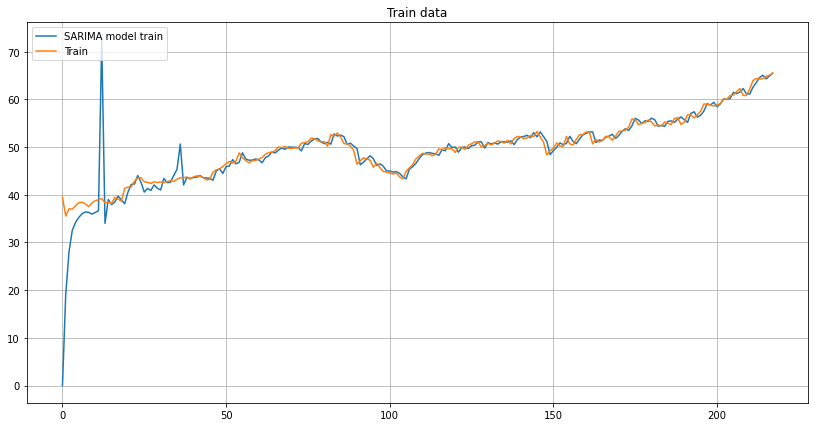

In [56]:
plt.figure(figsize=(14,7))
plt.title('Train data')
plt.plot (res.predict(), label= 'SARIMA model train')
plt.plot(df_train.reset_index(drop=True), label = 'Train')
plt.legend(loc='upper left')
plt.grid()

Сделаем прогноз на весь тестовый датасет

In [57]:
print('test data MAPE: ',mean_absolute_percentage_error(df_test['Close'].to_numpy(), res.predict(len(df_train), len(df_train) + len(df_test) - 1)))

test data MAPE:  0.01775834516985734


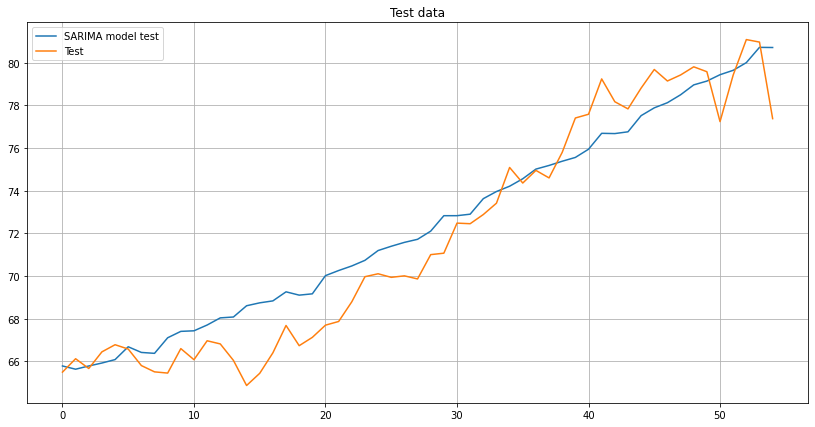

In [58]:
plt.figure(figsize=(14,7))
plt.title('Test data')
plt.plot(res.predict(len(df_train), len(df_train) + len(df_test) - 1), label= 'SARIMA model test')
plt.plot(df_test.reset_index(drop=True), label = 'Test')
plt.legend(loc='upper left')
plt.grid()

Короткий прогноз на 6 дней:

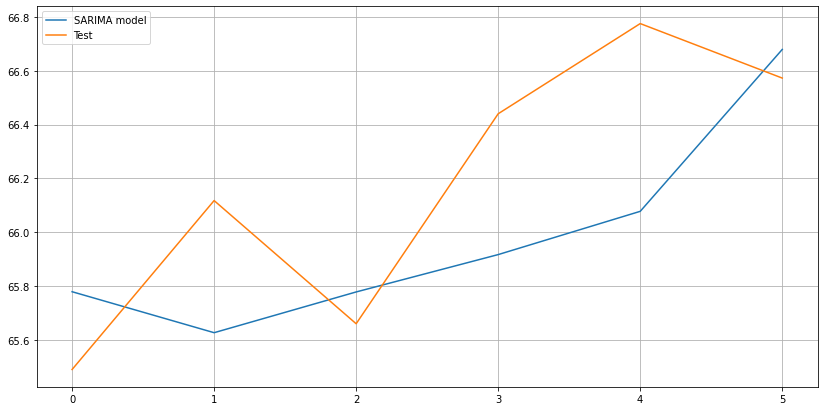

In [59]:
plt.figure(figsize=(14,7))
plt.plot(res.predict(len(df_train), len(df_train) + 5), label= 'SARIMA model')
plt.plot(df_test.reset_index(drop=True)[:6], label = 'Test')
plt.legend(loc='upper left')
plt.grid()

Длинный прогноз очень впечатляет, действиетльно самый точный из выше упомянутых моделей, однако короткий прогноз не самый точный.

## Simple Exponential Smoothing (SES) 

Обратимся к более простым моделям - Простое экспоненциальное сглаживание.

In [110]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(df_train['Close'].to_numpy())
res = model.fit(smoothing_level=0.8)
print(res.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                  218
Model:             SimpleExpSmoothing   SSE                            151.504
Optimized:                       True   AIC                            -75.326
Trend:                           None   BIC                            -68.557
Seasonal:                        None   AICC                           -75.138
Seasonal Periods:                None   Date:                 Wed, 21 Apr 2021
Box-Cox:                        False   Time:                         13:40:46
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8000000                alpha                False
initial_level              38.754874                

D:\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


Из SimpleExpSmoothing Model Results  выделим критерии AIC (Информационный критерий Акаике) и BIC (Байесовский информационный критерий).

AIC =  -75.326

BIC = -68.557

Тренировочная выборка:

In [111]:
print('train data MAPE: ',mean_absolute_percentage_error(df_train['Close'].to_numpy(), res.fittedvalues))

train data MAPE:  0.012429849347971346


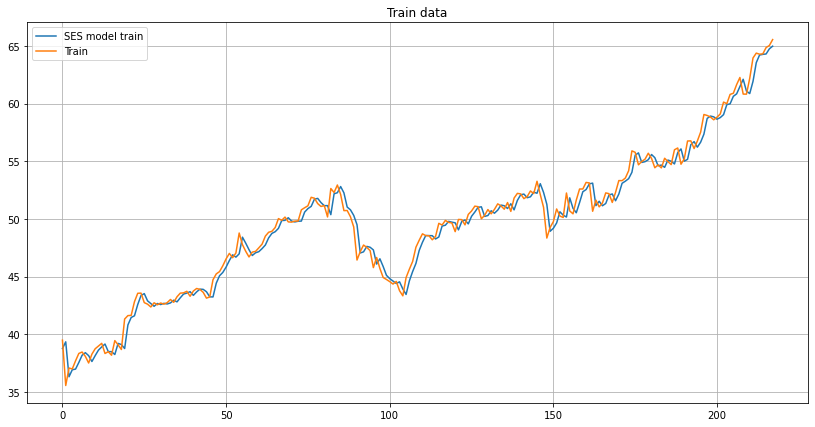

In [112]:
plt.figure(figsize=(14,7))
plt.title('Train data')
plt.plot (res.fittedvalues, label= 'SES model train')
plt.plot(df_train.reset_index(drop=True), label = 'Train')
plt.legend(loc='upper left')
plt.grid()

Сделаем прогноз на весь тестовый датасет

In [114]:
print('test data MAPE: ',mean_absolute_percentage_error(df_test['Close'].to_numpy(), res.predict(len(df_train), len(df_train) + len(df_test) - 1)))

test data MAPE:  0.08408885919719841


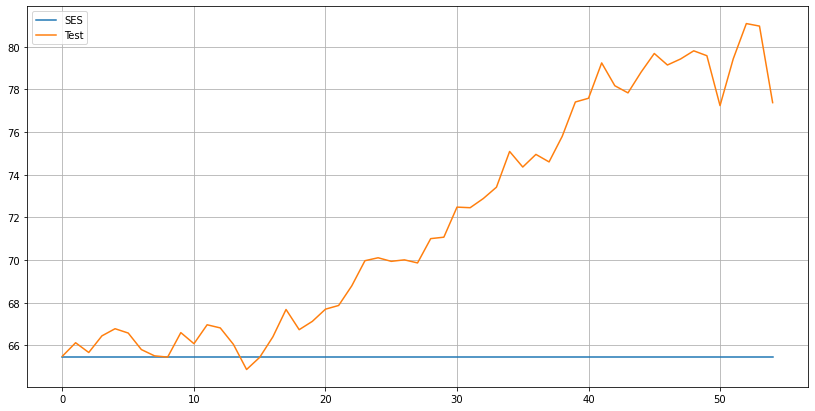

In [115]:
plt.figure(figsize=(14,7))
plt.plot(res.predict(len(df_train), len(df_train) + len(df_test) - 1), label= 'SES')
plt.plot(df_test.reset_index(drop=True), label = 'Test')
plt.legend(loc='upper left')
plt.grid()

## Holt Winter’s Exponential Smoothing (HWES) 

Сглаживание Хольтса - Винтерса

In [102]:
def SmoothingHW_config():
    models = []
    t_params = ['add', 'mul', 'additive', 'multiplicative']
    s_params =['add', 'mul', 'additive', 'multiplicative']
    sp_params = [0, 6, 12]
    sm_params = [0.2, 0.4, 0.6]
    for t in t_params:
        for s in s_params:
            for sp in sp_params:
                for sm in sm_params:
                    cfg = [t, s, sp, sm]
                    models.append(cfg)
    return models

In [103]:
cfg_list = SmoothingHW_config()
# grid search
scores = grid_search_sm(df_train['Close'].to_numpy(), df_test['Close'].to_numpy(), cfg_list)
clear_output(wait=True)
print('done\n')
print('TOP 3 scores : \n')
for cfg, res in scores[:3]:
    print(f'> Model {cfg},    MAPE {res}')

done

TOP 3 scores : 

> Model ['mul', 'mul', 6, 0.6],    MAPE 0.03238032624358724
> Model ['mul', 'multiplicative', 6, 0.6],    MAPE 0.03238032624358724
> Model ['multiplicative', 'mul', 6, 0.6],    MAPE 0.03238032624358724


Лучшие параметры модели:['mul', 'mul', 6, 0.6]

при этом MAPE =  0.03238032624358724

Построим данную модель

In [117]:
model = ExponentialSmoothing(df_train['Close'].to_numpy(), trend='mul', seasonal='mul', seasonal_periods=6)
res = model.fit(0.6)
print(res.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  218
Model:             ExponentialSmoothing   SSE                            154.463
Optimized:                         True   AIC                            -55.110
Trend:                   Multiplicative   BIC                            -21.265
Seasonal:                Multiplicative   AICC                           -53.588
Seasonal Periods:                     6   Date:                 Wed, 21 Apr 2021
Box-Cox:                          False   Time:                         13:41:49
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6000000                alpha                False
smoothing_trend          

D:\conda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


Из  ExponentialSmoothing Model Results  выделим критерии AIC (Информационный критерий Акаике) и BIC (Байесовский информационный критерий).

AIC =  -55.110

BIC = -21.265

Тренировочная выборка

In [118]:
print('train data MAPE: ',mean_absolute_percentage_error(df_train['Close'].to_numpy(), res.fittedvalues))

train data MAPE:  0.012645765504606847


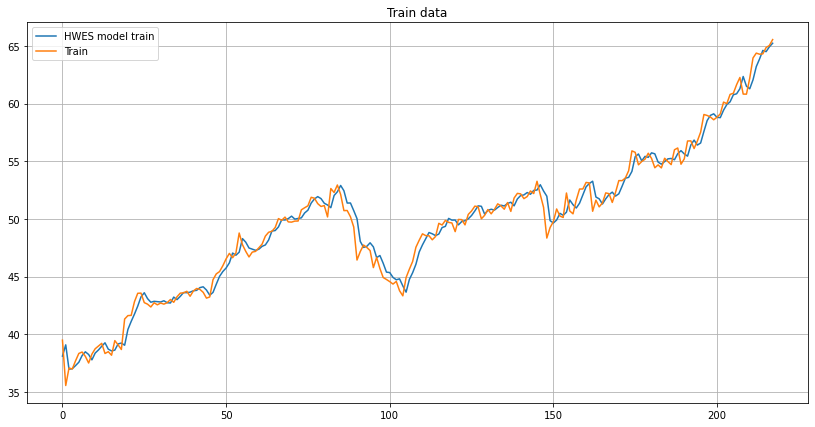

In [119]:
plt.figure(figsize=(14,7))
plt.title('Train data')
plt.plot (res.fittedvalues, label= 'HWES model train')
plt.plot(df_train.reset_index(drop=True), label = 'Train')
plt.legend(loc='upper left')
plt.grid()

Прогноз на тесте

In [108]:
print('test data MAPE: ',mean_absolute_percentage_error(df_test['Close'].to_numpy(), res.predict(len(df_train), len(df_train) + len(df_test) - 1)))

test data MAPE:  0.03238032624358724


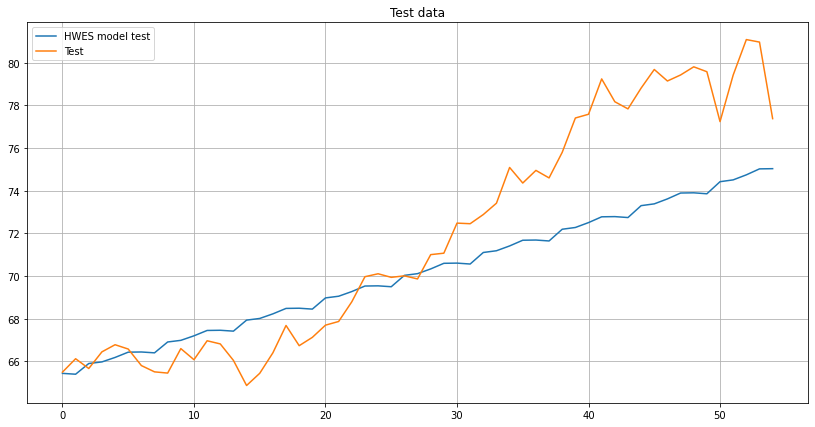

In [120]:
plt.figure(figsize=(14,7))
plt.title('Test data')
plt.plot(res.predict(len(df_train), len(df_train) + len(df_test) - 1), label= 'HWES model test')
plt.plot(df_test.reset_index(drop=True), label = 'Test')
plt.legend(loc='upper left')
plt.grid()

# Вывод

Хуже всех сработала модель MA, затем модели : Простое экспоненциальное сглаживание и Сглаживание Хольтса - Винтерса.

Гораздо лучше себя показали ARMA, AR, ARIMA

Самый лучший прогноз получился при использовании SARIMA.

Результаты приведены в таблице ниже:

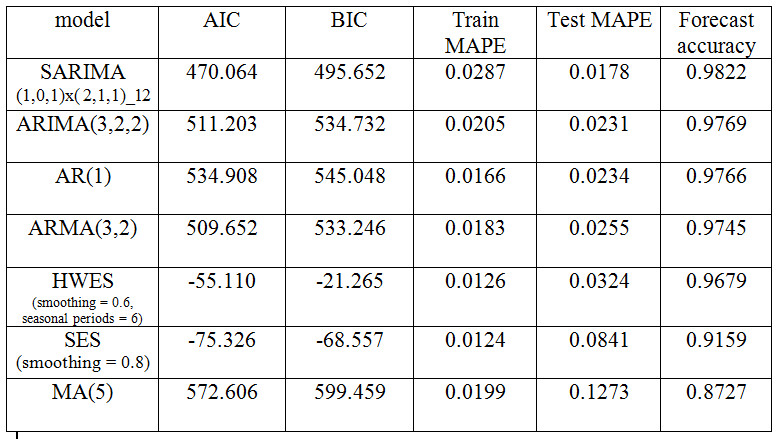

In [1]:
from IPython.display import Image
Image(filename='results.jpg')